In [32]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        print(dataset[fold])
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)
    images=np.array(dataset['fold_0']['x'])
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    return images, ds


def test_result_extraction(filename):
    """Parameters:
    -----------
    filename : str
        Path to the HDF5 file containing the prediction results.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the predicted values, true labels and probabilities for each patient.
        The index of the DataFrame is the patient ID.
    """
    # Open the HDF5 file and extract the necessary data
    f = h5py.File(filename, 'r')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:])
    f.close()

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({'pred':pred.flatten(),'label': y.flatten()},index=patient)

    # Add a column for the predicted probabilities rounded to two decimal places
    df['prob']=np.round(df['pred'],2)

    # Round the predicted values to the nearest integer
    df['pred']=np.round(df['pred'],0)

    return df

       
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/ sklerose','2, artrose', '2, MCD',
               '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['label'],df['pred'])
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Confusion matrix with absolute numbers')
    plt.show()

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['label'],df['pred'], normalize='true')
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Normalisert confusion matrix. (normalisert over sann diagnose)')
    plt.show()

    df['result']= 'Correct'
    df.loc[wrong,('result')] = 'Wrong'
    df_wrong = df[df.result=='Wrong']
    df_wrong['true']=original_dataset.diagnosis.loc[wrong]
    df_wrong = df_wrong.drop(['result','label'],axis=1)

    plt.figure()
    plt.title('Feilklassifiserte prøver')
    sns.histplot(df[df['result']=='Wrong'], x='prob', bins=100)
    
    plt.figure()
    plt.title('Rett predikerte prøver')
    sns.histplot(df[df['result']=='Correct'], x='prob', bins=100)

    plt.figure()
    #plt.xticks(np.unique(original_dataset.diagnosis),diagnoses,rotation=45)
    sns.countplot(x='diagnosis',data=original_dataset.set_index('ID').loc[wrong]) # Bruker originalt datasett for å få alle diagnosene
    #plt.xticks([0,1,2,3,4], ['normal','1, artrose/ \nsklerose','2, artrose', '2, MCD', '3, MCD'])
    plt.title('Fordeling av feilpredikerte av hver diagnose')
    plt.show()
    
    if show_images==True:
        for i in wrong:
                    
                plt.figure()
                plt.imshow(images[original_dataset[original_dataset.ID==i].index[0]],'gray')
                plt.axis('off')
                plt.title('ID: {}, True: {}, Predicted: {:.2f}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                        diagnoses[int(original_dataset.diagnosis[original_dataset.ID==i].values[0])],
                                                                        df.prob[i]))
                plt.show()

    return df_wrong

In [11]:
images, ds = image_extraction('//nmbu.no/Research/Project/CubiAI/preprocess/datasets/800_ext_binary_2.h5')
df = test_result_extraction('prediction_external.h5')


<HDF5 group "/fold_0" (4 members)>
<HDF5 group "/fold_1" (4 members)>
<HDF5 group "/fold_2" (4 members)>
<HDF5 group "/fold_3" (4 members)>


Fetching all datasets of test data and making one dataframe of all of them, then closing the file.

<Figure size 640x480 with 0 Axes>

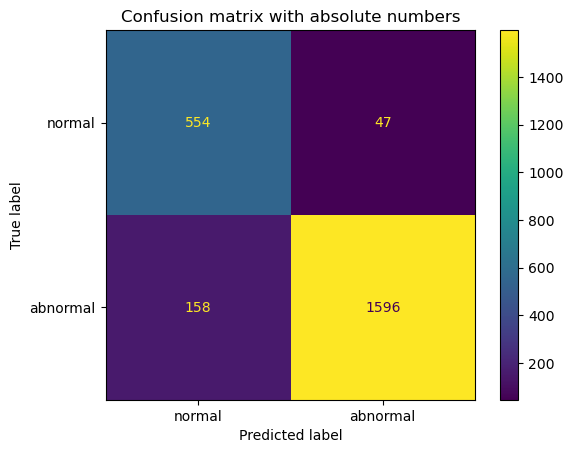

<Figure size 640x480 with 0 Axes>

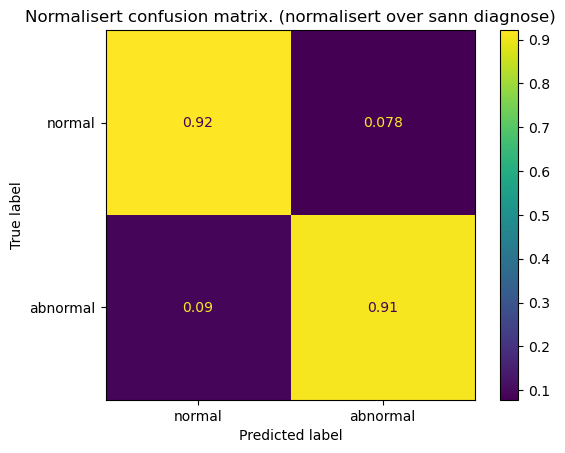

C:\NMBU\TEMP\ipykernel_17716\1453914060.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrong['true']=original_dataset.diagnosis.loc[wrong]


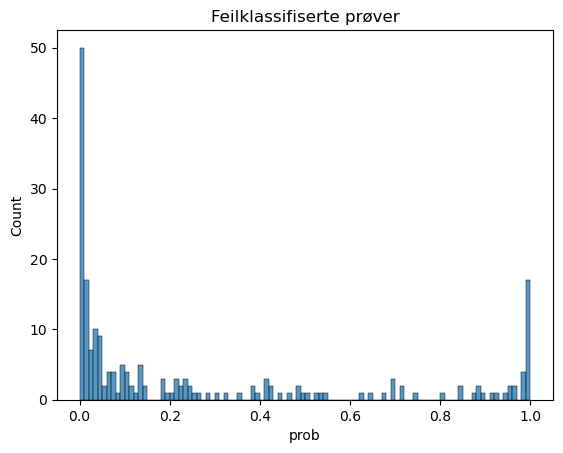

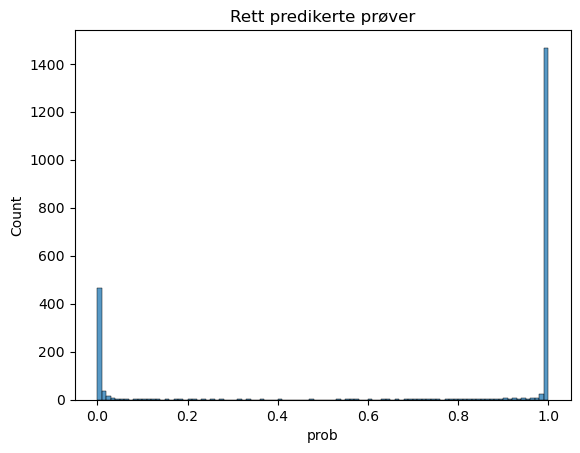

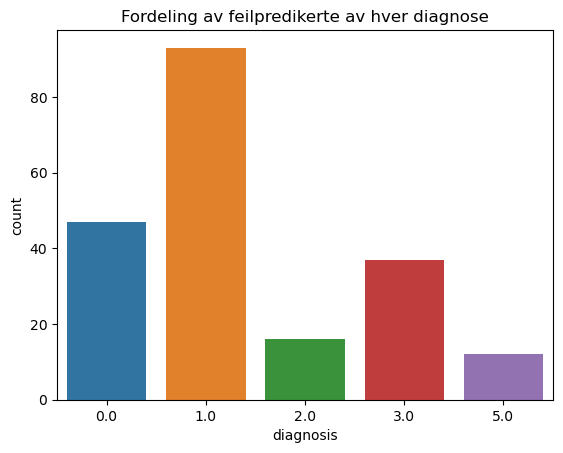

In [33]:
l=check_wrong(df,show_images=False, original_dataset=ds,images=images)


In [5]:
l

['ID: 839, prob: 0.00, True: 3.0',
 'ID: 877, prob: 0.99, True: 0.0',
 'ID: 183, prob: 0.92, True: 0.0',
 'ID: 171, prob: 0.03, True: 5.0',
 'ID: 346, prob: 0.00, True: 1.0',
 'ID: 385, prob: 0.00, True: 1.0',
 'ID: 1029, prob: 0.46, True: 2.0',
 'ID: 210, prob: 0.27, True: 2.0',
 'ID: 191, prob: 0.99, True: 0.0',
 'ID: 466, prob: 0.00, True: 1.0',
 'ID: 493, prob: 0.17, True: 1.0',
 'ID: 970, prob: 0.73, True: 0.0',
 'ID: 846, prob: 0.98, True: 0.0',
 'ID: 377, prob: 1.00, True: 0.0',
 'ID: 116, prob: 0.33, True: 1.0',
 'ID: 1011, prob: 0.00, True: 1.0',
 'ID: 725, prob: 0.20, True: 5.0',
 'ID: 893, prob: 0.67, True: 0.0',
 'ID: 174, prob: 1.00, True: 0.0']